In [60]:
import joblib
import glob
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.spatial.distance as dst
import matplotlib as mpl
import itertools
from matplotlib.colors import LinearSegmentedColormap

In [61]:
colors = {
    'C': 'navy',
    'G': 'seagreen',
    'N': 'orangered',
    'GB':'crimson',
    'CB':'darkorchid',
    'GM':'mediumturquoise',
    'CM':'darkcyan',
}
def bname(m, c, g=None):
    gtype = 'a' if 'synth' in m else ''
    if c in ['GB','CB','N','GM']:
        return f"ep_{m}_{c}_g{g}{gtype}_snr0"
    elif c=='CM':
        return f"ep_{m}_{c}_snr0"
    elif c=='C':
        return f"ep_{m}_{c}"
    elif c=='G':
        return f"ep_{m}_{c}_g{g}{gtype}"
def generate_colormap(color, linspace=16):
    rgb_vals = mpl.colors.to_rgb(color)
    x = np.array([np.linspace(i,0.92,16) for i in rgb_vals])
    cm = LinearSegmentedColormap.from_list(
        'listname', x.T, N=16
    )
    return cm, np.append(x, np.repeat(1, 16)[:, None].T, axis=0)

In [62]:
dataset = 'naive'
method = 'pls'
win = 100
nbasis = 15
training_conditions = ['C', 'G', 'N', 'CM']
ncomps = np.arange(50, 0, -1)

In [63]:
exp = 'nat8b'
gaplocs = [1,2]
stim_info = pd.read_csv(f'../../inputs/stimuli_lists/{exp}_info.csv', index_col='stimulus')
motifs = stim_info.motif.unique()
spectrograms = pd.read_csv(f'/scratch/bple/induction/{exp}/spectrograms.csv', index_col=['stimulus', 'time'])
spectrograms.sort_index(inplace=True)

dsetdata = []
for h5file in glob.glob(f"/scratch/bple/induction/{exp}/{dataset}/**_delemb_win{win}_basis{nbasis}.h5"):
    print(h5file)
    dsetdata.append(pd.read_hdf(h5file, key='Induction'))
responses = pd.concat(dsetdata, axis=1)

model_file = f"/scratch/bple/induction/models/{exp}/{dataset}_master_{method}_model_win{win}_basis{nbasis}.pkl"
models = joblib.load(model_file)
model = models['model']

projections = []
for m in motifs:
    cstim = spectrograms.loc[bname(m, 'C', None)]
    for g in gaplocs:
        ga, gb = stim_info.set_index(['motif','gap','type']).loc[m, g, 'G'][['gap_start', 'gap_stop']]
        ga = int(ga)
        gb = int(gb)
        for c in ['C','G','CB', 'GB', 'N', 'GM', 'CM']:
            stim = bname(m, c, g)
            X = model.transform(
                X = responses.loc[stim].loc[ga:gb]
            )
            projections.append({
                'motif': m,
                'gap': g,
                'condition': c,
                'projections': X
            })
result = pd.DataFrame(projections).set_index(['motif', 'gap', 'condition'])


# colors = [mpl.colormaps['plasma'](x) for x in np.linspace(0,1,16)]
distmap = []
for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
    CI_proj = result.loc[m, g, 'C'].projections[:,:3]
    CI_dist = [dst.euclidean(x, [1,-1,-2]) for x in CI_proj]
    distmap.append({
        'motif':m,
        'gap':g,
        'avg': np.mean(CI_dist)
    })
distmap = pd.DataFrame(distmap).sort_values('avg')
distmap['distrank'] = np.arange(16)
distmap['viridiscolor'] = [mpl.colormaps['viridis'](x) for x in np.linspace(0,1,16)]
distmap.set_index(['motif','gap'], inplace=True)

/scratch/bple/induction/nat8b/naive/Rb279_delemb_win100_basis15.h5
/scratch/bple/induction/nat8b/naive/C49_delemb_win100_basis15.h5
/scratch/bple/induction/nat8b/naive/C54a_delemb_win100_basis15.h5
/scratch/bple/induction/nat8b/naive/C43_delemb_win100_basis15.h5
/scratch/bple/induction/nat8b/naive/Rb291_delemb_win100_basis15.h5


In [ ]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 2

# cmap_vals = np.linspace(0,1,16)
# clbax = plt.figure().add_subplot()
# gradient = np.vstack((cmap_vals, cmap_vals, cmap_vals))
# clbax.imshow(gradient, cmap='plasma', aspect=2)
# clbax.set_xticklabels([],distmap.index.get_)
# clbax.set_yticks([])

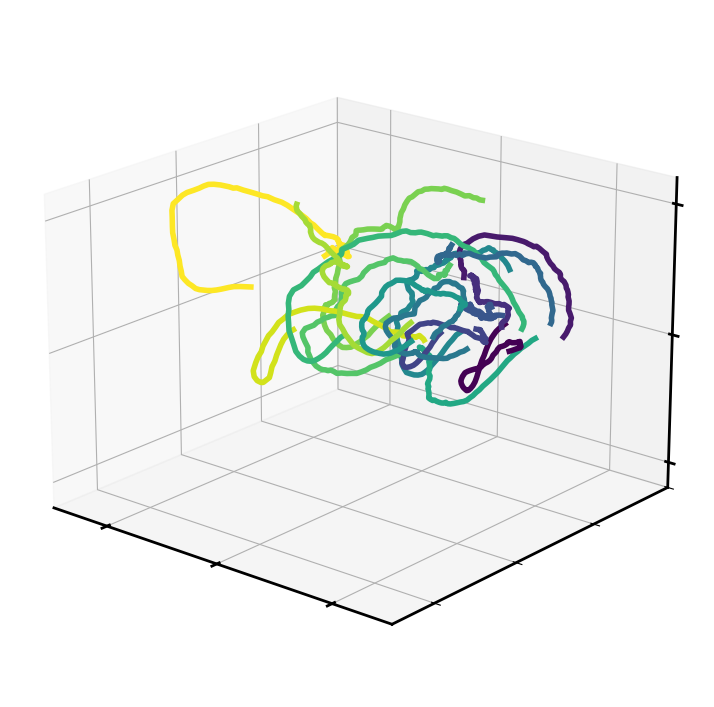

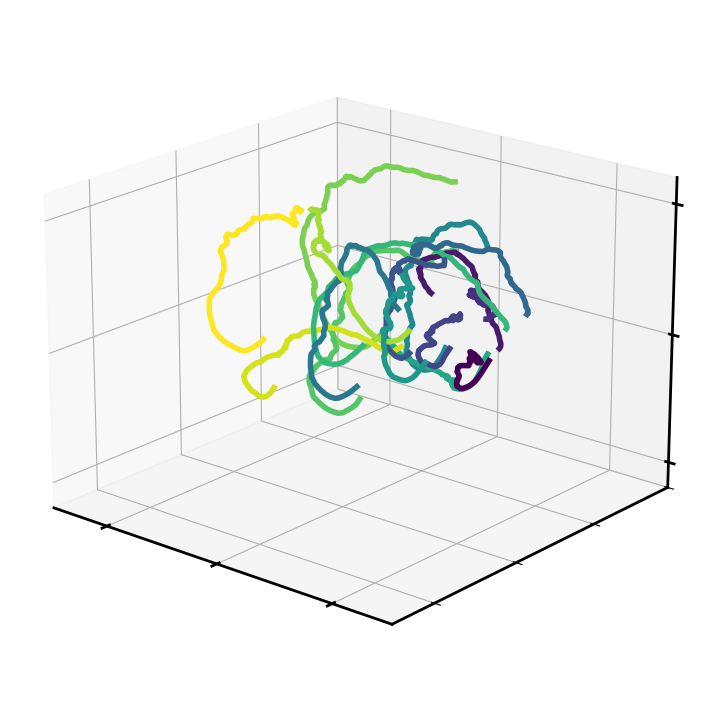

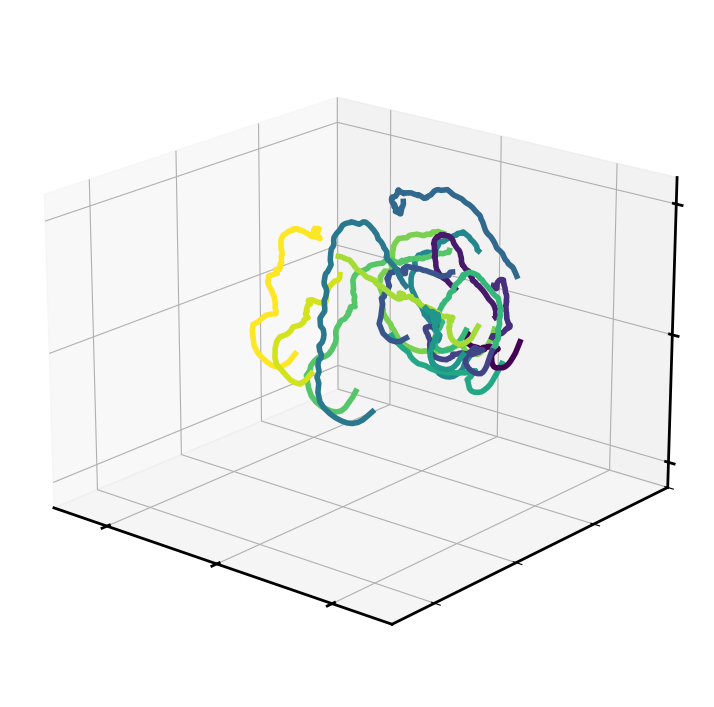

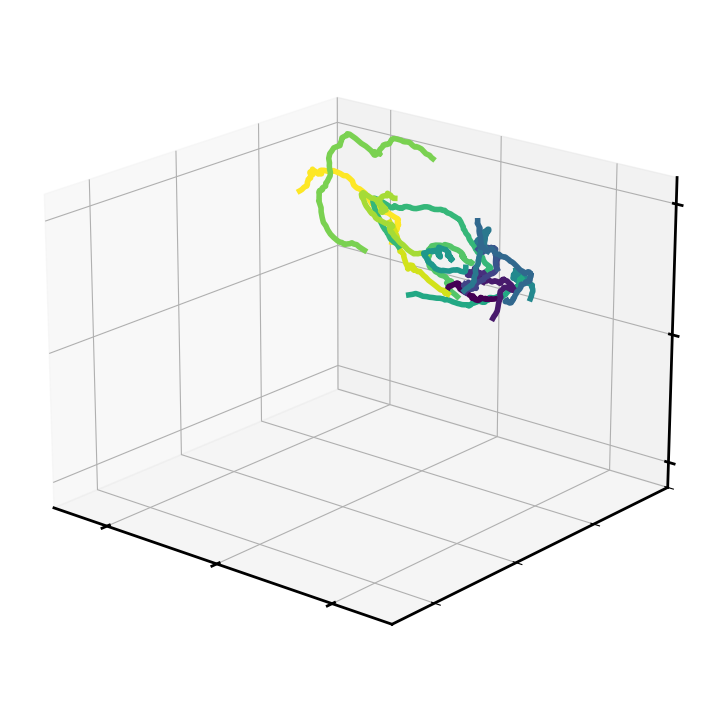

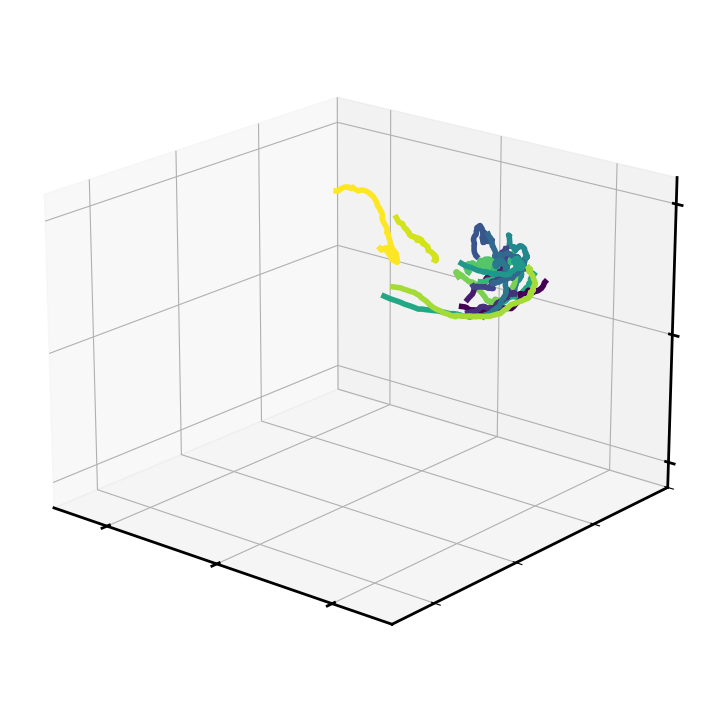

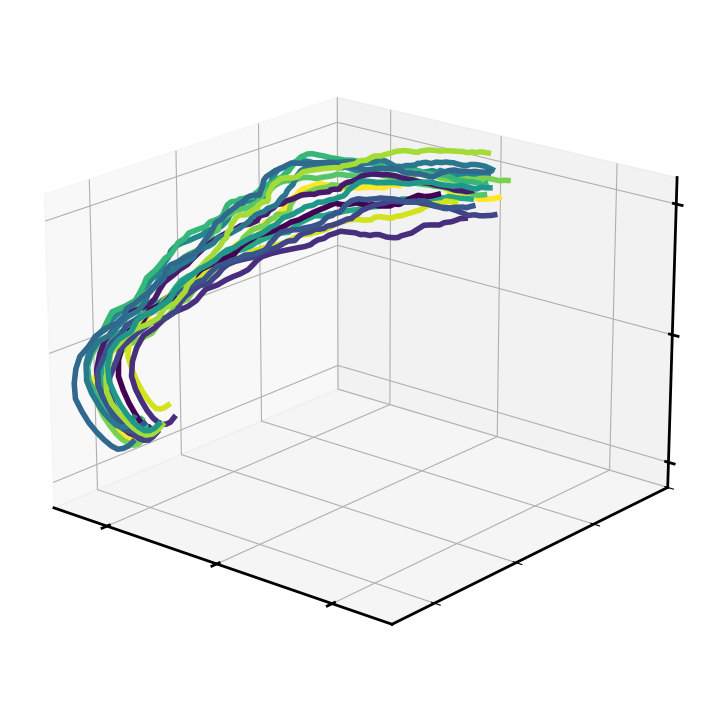

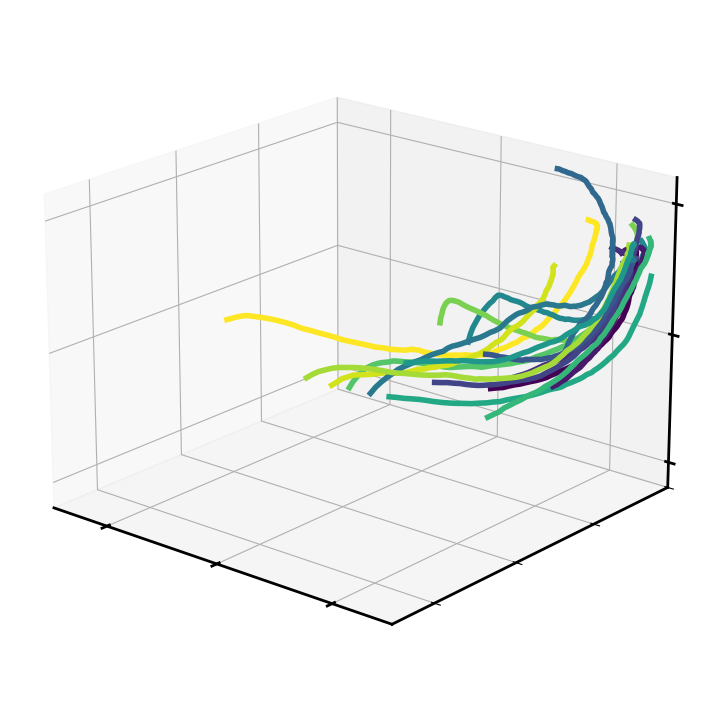

In [85]:
for c in ['C','CB','GB','CM','GM','N','G']:
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1,9,(2,9),projection='3d')
    plt.setp(ax.spines.values(), lw=3, color='black')
    cm, colormap = generate_colormap(colors[c])
    for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
        projs = result.loc[m, g, c].projections
        img = ax.plot(
            projs[:, 0],
            projs[:, 1],
            projs[:, 2],
            alpha=1,
            color= distmap.loc[m,g].viridiscolor,
            lw=4
        )
    ax.view_init(elev=20, azim=130, roll=0)
    ax.set_xlim(0.5,3.5)
    ax.set_xticks([1,2,3], [])
    ax.set_ylim(-0.5,2.5)
    ax.set_yticks([-1,0,1,2], [])
    ax.set_zlim(-2.2,0.2)
    ax.set_zticks([-2,-1,0], [])
    if colbar:
        clbax = fig.add_subplot(1,9,1)
        gradient = np.linspace(0,1,16)
        gradient = np.vstack((gradient, gradient))
        clbax.imshow(gradient.T, cmap=cm, aspect=2)
        clbax.set_xticks([])
        clbax.set_yticks([])

[]

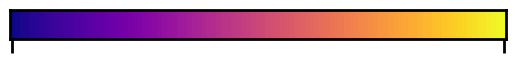

In [83]:
max_proj = result.apply(lambda row: row.projections.shape[0], axis=1).max()
cmap_vals = np.linspace(0,1,max_proj)
plt.rcParams['axes.linewidth'] = 2

plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 2

clbax = plt.figure().add_subplot()
gradient = np.vstack((cmap_vals, cmap_vals, cmap_vals))
clbax.imshow(gradient, cmap='plasma', aspect=2)
clbax.set_xticks([0,max_proj-1],[])
clbax.set_yticks([])

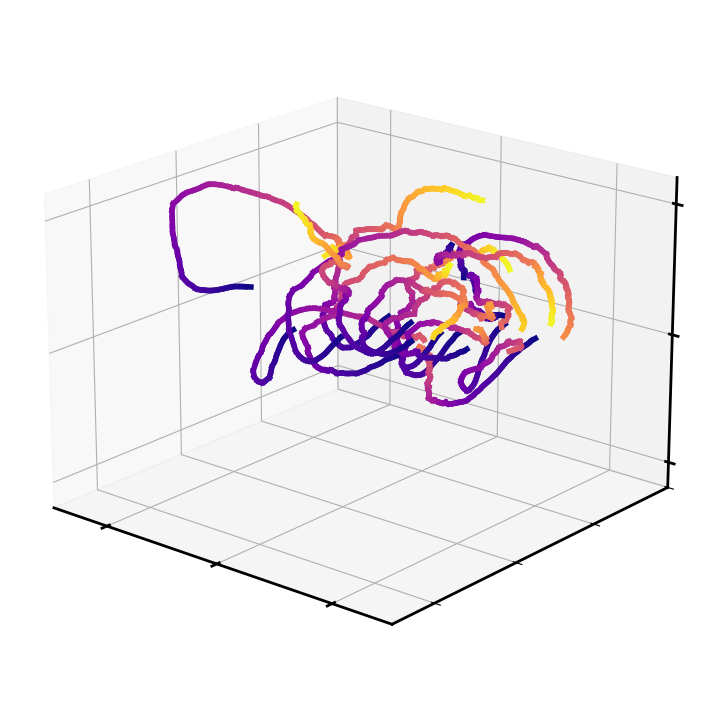

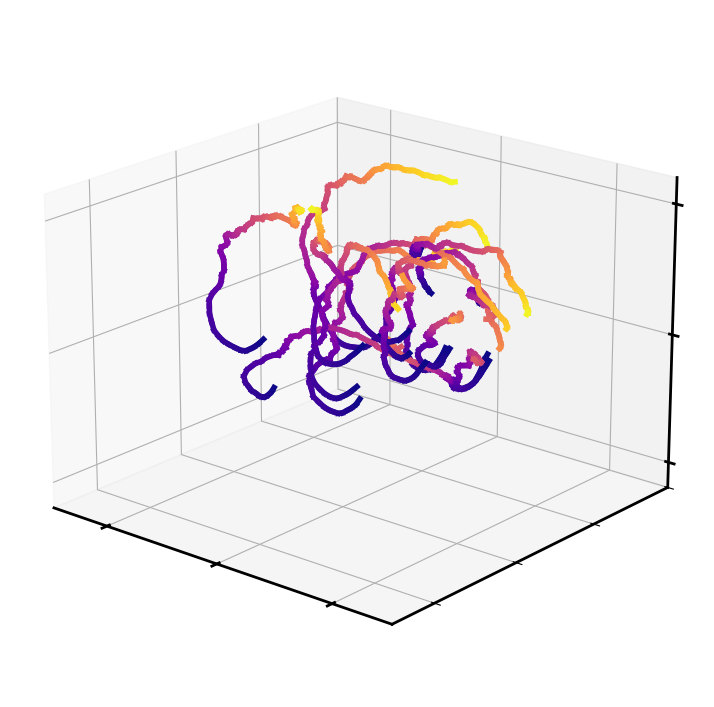

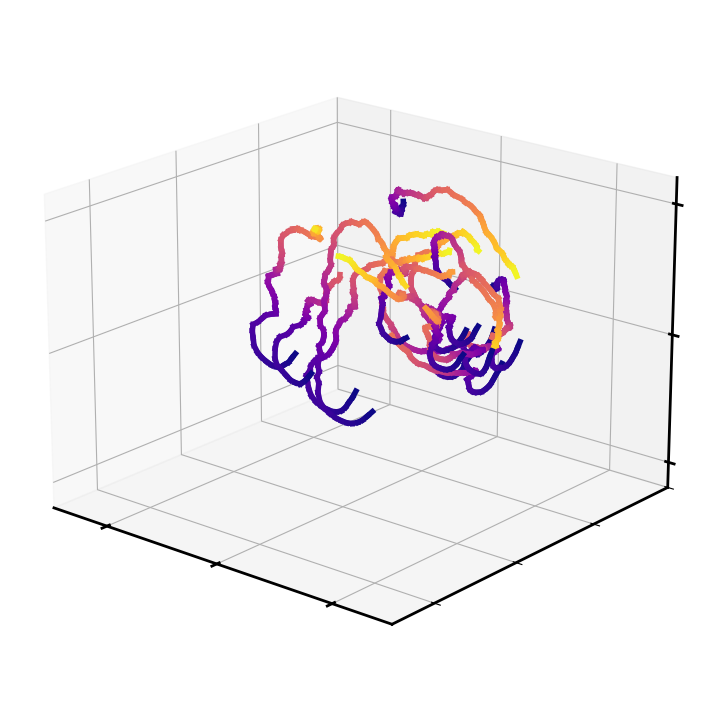

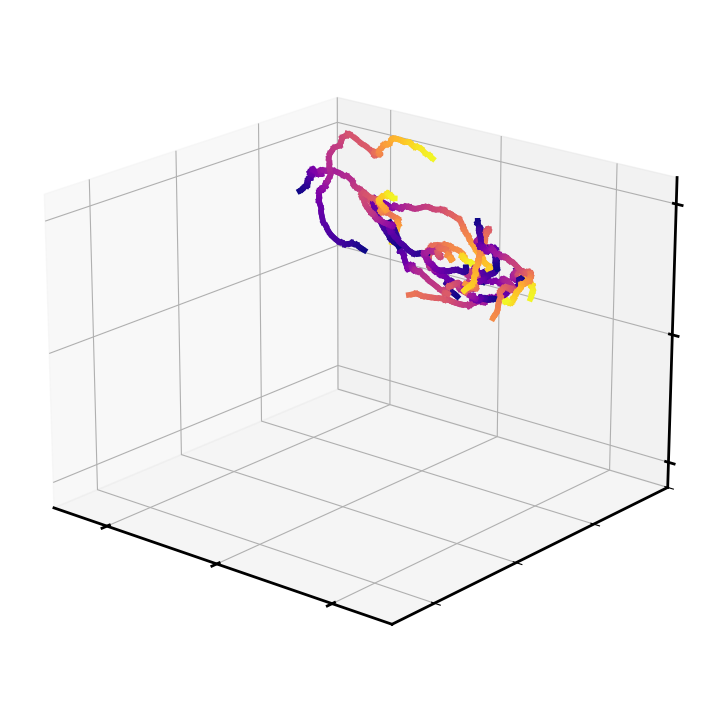

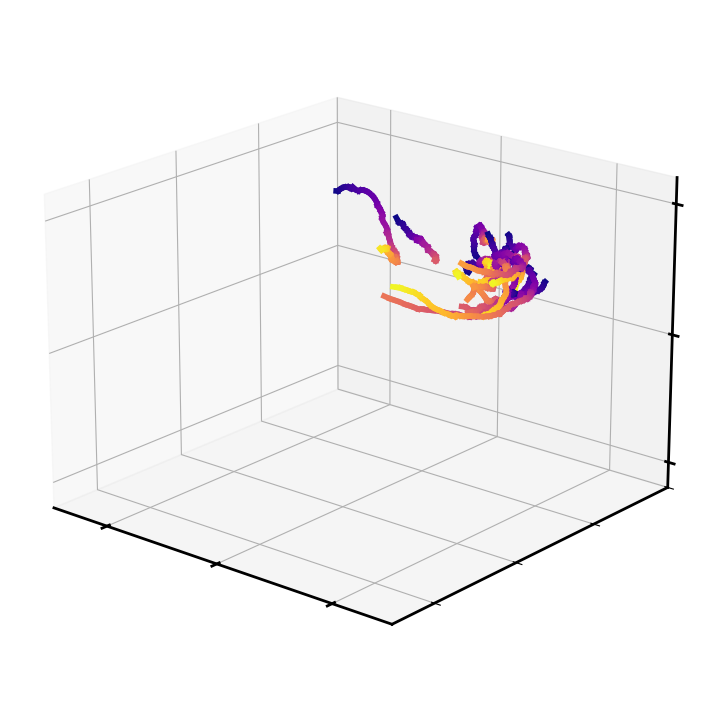

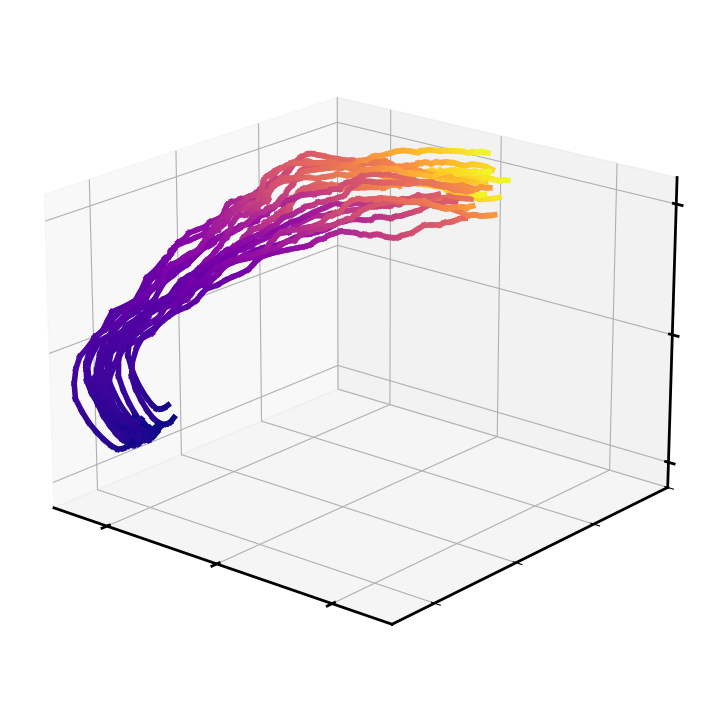

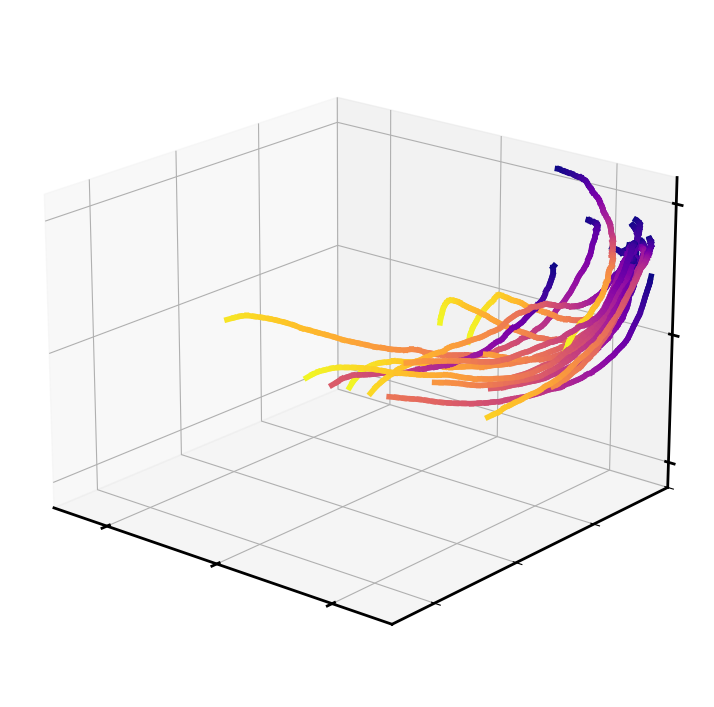

In [95]:
for c in ['C','CB','GB','CM','GM','N','G']:
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1,9,(2,9),projection='3d')
    plt.setp(ax.spines.values(), lw=3, color='black')
    for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
        projs = result.loc[m, g, c].projections
        for idx in range(projs.shape[0]-1):
            ax.plot(
                projs[idx:idx+2, 0],
                projs[idx:idx+2, 1],
                projs[idx:idx+2, 2],
                alpha=1,
                color=mpl.colormaps['plasma'](cmap_vals[idx]),
                #cmap='plasma',#colormap[:,int(distmap.loc[m,g].distrank)],
                lw=4
            )
    ax.view_init(elev=20, azim=130, roll=0)
    ax.set_xlim(0.5,3.5)
    ax.set_xticks([1,2,3], [])
    ax.set_ylim(-0.5,2.5)
    ax.set_yticks([-1,0,1,2], [])
    ax.set_zlim(-2.2,0.2)
    ax.set_zticks([-2,-1,0], [])


In [58]:
exp = 'synth8b'
gaplocs=[2,4]
stim_info = pd.read_csv(f'../../inputs/stimuli_lists/{exp}_info.csv', index_col='stimulus')
motifs = stim_info.motif.unique()
spectrograms = pd.read_csv(f'/scratch/bple/induction/{exp}/spectrograms.csv', index_col=['stimulus', 'time'])
spectrograms.sort_index(inplace=True)

dsetdata = []
for h5file in glob.glob(f"/scratch/bple/induction/{exp}/{dataset}/**_delemb_win{win}_basis{nbasis}.h5"):
    print(h5file)
    dsetdata.append(pd.read_hdf(h5file, key='Induction'))
responses = pd.concat(dsetdata, axis=1)

model_file = f"/scratch/bple/induction/models/{exp}/{dataset}_master_{method}_model_win{win}_basis{nbasis}.pkl"
models = joblib.load(model_file)
model = models['model']

projections = []
for m in motifs:
    cstim = spectrograms.loc[bname(m, 'C', None)]
    for g in gaplocs:
        ga, gb = stim_info.set_index(['motif','gap','type']).loc[m, g, 'G'][['gap_start', 'gap_stop']]
        ga = int(ga)
        gb = int(gb)
        for c in ['C','G','CB', 'GB', 'N', 'GM', 'CM']:
            stim = bname(m, c, g)
            X = model.transform(
                X = responses.loc[stim].loc[ga:gb]
            )
            projections.append({
                'motif': m,
                'gap': g,
                'condition': c,
                'projections': X
            })
result = pd.DataFrame(projections).set_index(['motif', 'gap', 'condition'])


# colors = [mpl.colormaps['plasma'](x) for x in np.linspace(0,1,16)]
distmap = []
for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
    CI_proj = result.loc[m, g, 'C'].projections[:,:3]
    CI_dist = [dst.euclidean(x, [1,-1,-2]) for x in CI_proj]
    distmap.append({
        'motif':m,
        'gap':g,
        'avg': np.mean(CI_dist)
    })
distmap = pd.DataFrame(distmap).sort_values('avg')
distmap['distrank'] = np.arange(16)
distmap['viridiscolor'] = [mpl.colormaps['plasma'](x) for x in np.linspace(0,1,16)]
distmap.set_index(['motif','gap'], inplace=True)

/scratch/bple/induction/synth8b/naive/Rb279_delemb_win100_basis15.h5
/scratch/bple/induction/synth8b/naive/C49_delemb_win100_basis15.h5
/scratch/bple/induction/synth8b/naive/Rb291_delemb_win100_basis15.h5
/scratch/bple/induction/synth8b/naive/C43_delemb_win100_basis15.h5
/scratch/bple/induction/synth8b/naive/C54a_delemb_win100_basis15.h5


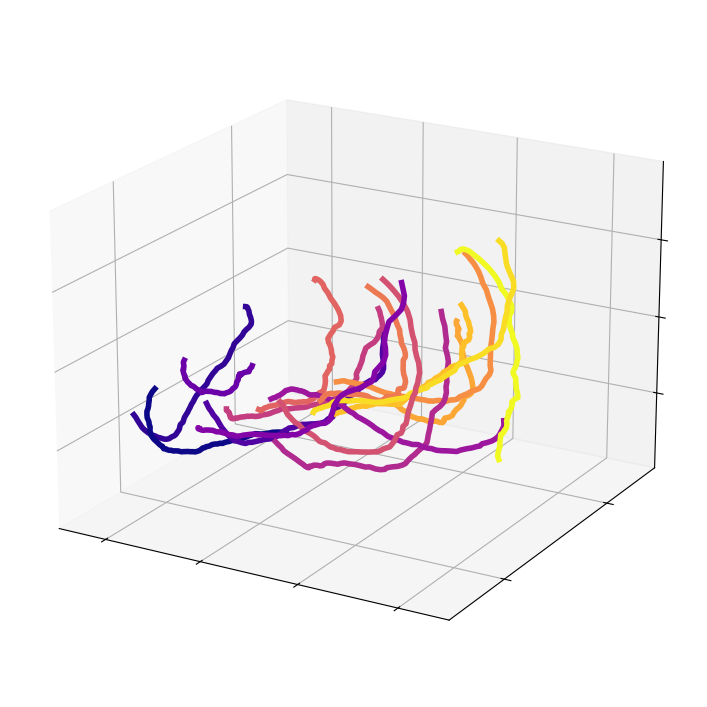

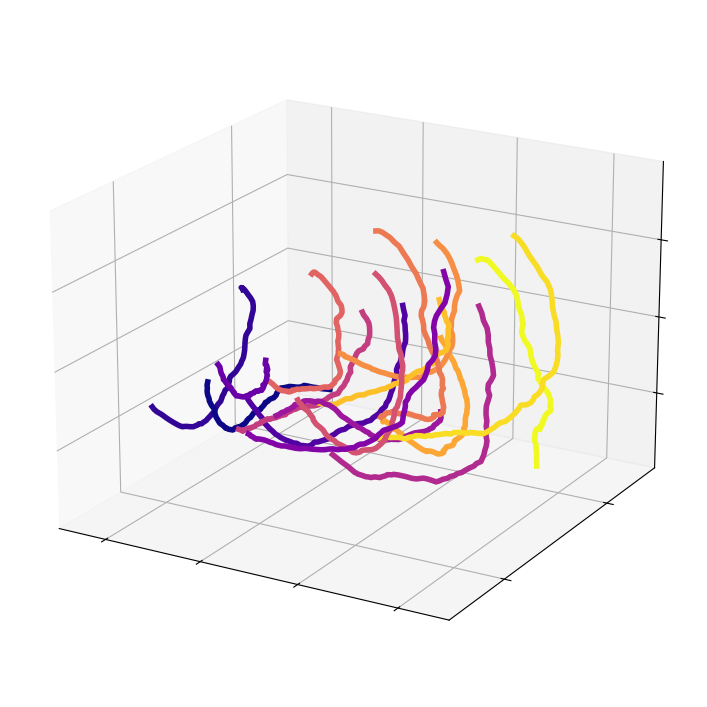

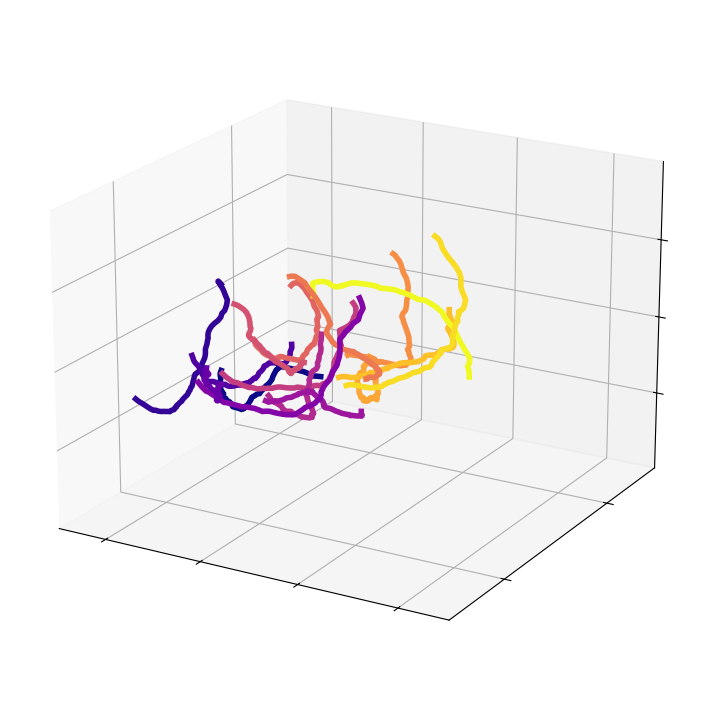

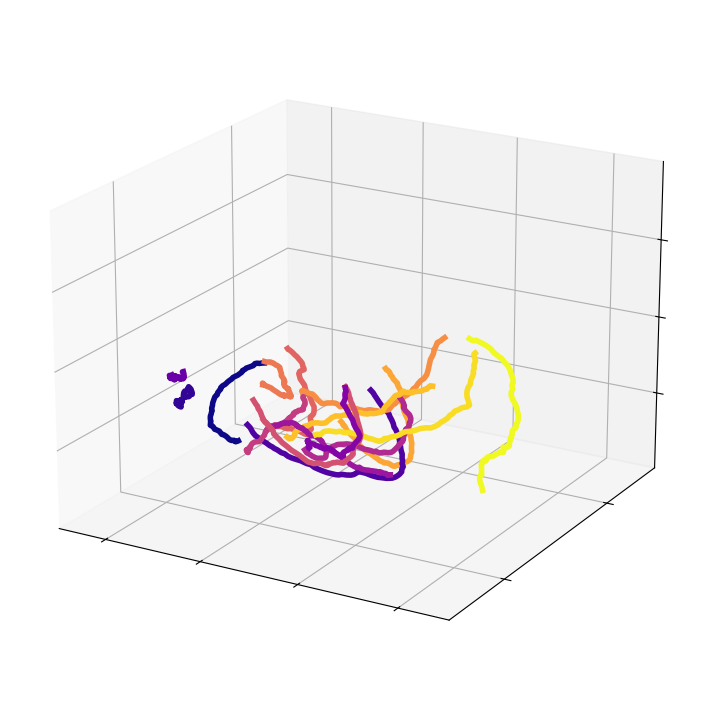

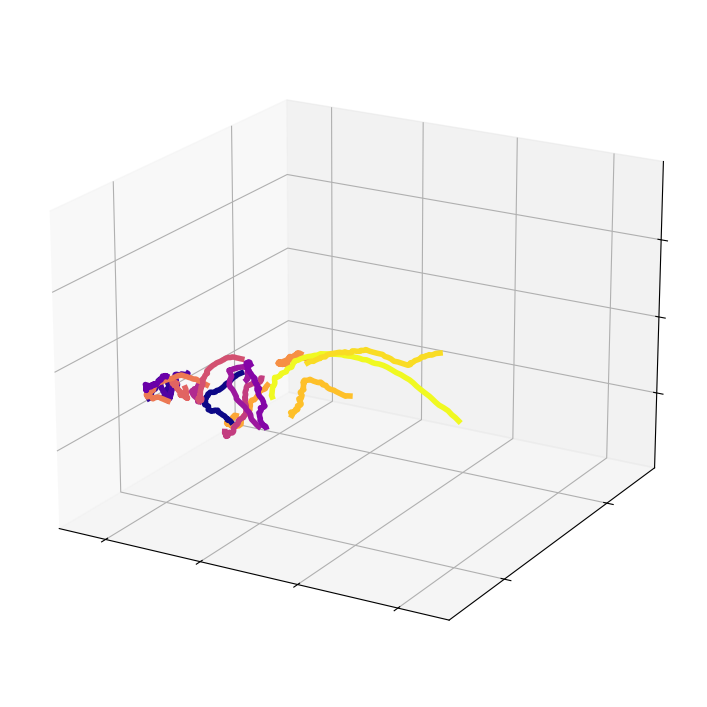

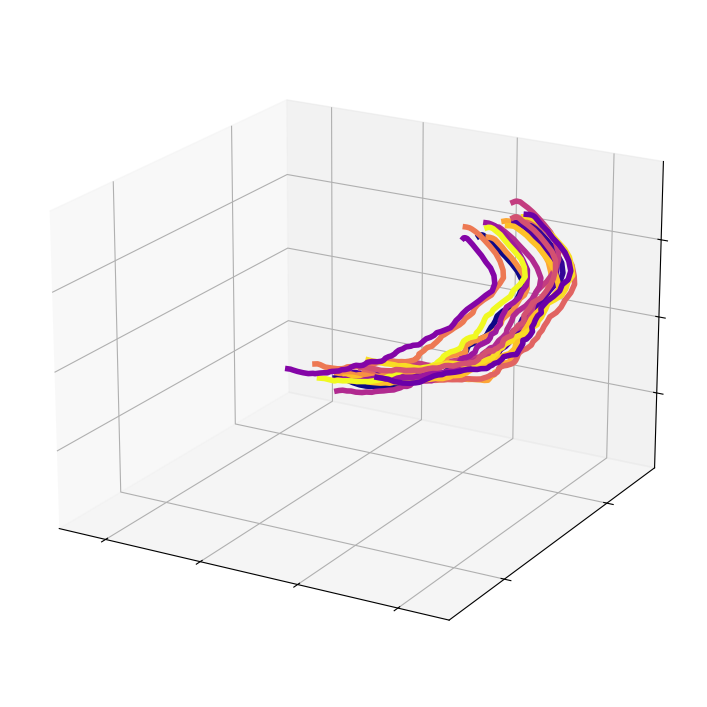

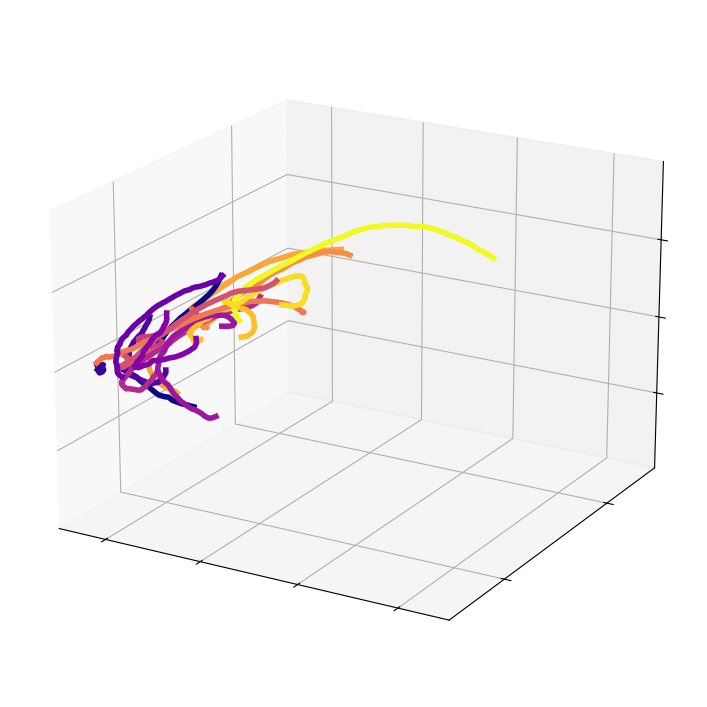

In [59]:
colbar = False
for c in ['C','CB','GB','CM','GM','N','G']:
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1,9,(2,9),projection='3d')
    plt.setp(ax.spines.values(), lw=3, color='black')
    cm, colormap = generate_colormap(colors[c])
    for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
        projs = result.loc[m, g, c].projections
        img = ax.plot(
            projs[:, 0],
            projs[:, 1],
            projs[:, 2],
            alpha=1,
            color= distmap.loc[m,g].viridiscolor,#colormap[:,int(distmap.loc[m,g].distrank)],
            lw=4
        )
    ax.view_init(elev=20, azim=-60, roll=0)
    ax.set_xlim(-0.5,3.5)
    ax.set_xticks([0,1,2,3], [])
    ax.set_ylim(0.5,2.5)
    ax.set_yticks([1,2], [])
    ax.set_zlim(-2,2)
    ax.set_zticks([-1,0,1], [])
    if colbar:
        clbax = fig.add_subplot(1,9,1)
        gradient = np.linspace(0,1,16)
        gradient = np.vstack((gradient, gradient))
        clbax.imshow(gradient.T, cmap=cm, aspect=2)
        clbax.set_xticks([])
        clbax.set_yticks([])